In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
import torch.optim as optim

In [3]:
#! Hyperparameters

# 1 layer of 50 neurons
# loss function: mean root square error
# optimizer: stochastic gradient descent
# epocs = 200

batch_size = 64
validation = .2
learning_rate = .01
seed = 42

In [4]:
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [5]:
df = pd.read_csv("Data/Processed/data.csv")
X = df.loc[:, df.columns != 'glucose_t+1']
y = df["glucose_t+1"]

In [6]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state = seed)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state = seed)

train_data = TabularDataset(X_train, y_train)
val_data = TabularDataset(X_val, y_val)
test_data = TabularDataset(X_test, y_test)

In [7]:
train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)
validation_loader = DataLoader(val_data, batch_size=batch_size) 

In [8]:
# Define the Neural Network
class BaseLine(nn.Module):
    def __init__(self, input_dim):
        super(BaseLine, self).__init__()
        self.fc = nn.Linear(input_dim, 50)
        self.output = nn.Linear(50, 1)

    def forward(self, x):
        x = torch.relu(self.fc(x))
        return self.output(x)

# Initialize model, optimizer
input_dim = X.shape[1]
model = BaseLine(input_dim=input_dim)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Define MRSE Loss Function
def MRSELoss(preds, targets):
    return torch.sqrt(nn.MSELoss()(preds, targets))

# Training & Validation
num_epochs = 600
train_loss_mrse = []
val_loss_mrse = []
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_X, batch_y in train_loader:
        batch_y = batch_y.view(-1, 1).float()
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = MRSELoss(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_loss_mrse.append(avg_train_loss)

    # --- Validation ---
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for val_X, val_y in validation_loader:
            val_y = val_y.view(-1, 1).float()
            preds = model(val_X)
            loss = MRSELoss(preds, val_y)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(validation_loader)
    val_loss_mrse.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | Train MRSE: {avg_train_loss:.4f} | Val MRSE: {avg_val_loss:.4f}")


Epoch 1/600 | Train MRSE: 159.1481 | Val MRSE: 151.0114
Epoch 2/600 | Train MRSE: 161.6468 | Val MRSE: 150.7086
Epoch 3/600 | Train MRSE: 151.7764 | Val MRSE: 150.2720
Epoch 4/600 | Train MRSE: 149.4125 | Val MRSE: 149.8890
Epoch 5/600 | Train MRSE: 154.7276 | Val MRSE: 149.4914
Epoch 6/600 | Train MRSE: 150.5639 | Val MRSE: 149.0680
Epoch 7/600 | Train MRSE: 149.2755 | Val MRSE: 148.6572
Epoch 8/600 | Train MRSE: 152.8531 | Val MRSE: 148.2837
Epoch 9/600 | Train MRSE: 149.3622 | Val MRSE: 147.8697
Epoch 10/600 | Train MRSE: 148.9492 | Val MRSE: 147.4562
Epoch 11/600 | Train MRSE: 148.5367 | Val MRSE: 147.0432
Epoch 12/600 | Train MRSE: 148.1246 | Val MRSE: 146.6305
Epoch 13/600 | Train MRSE: 147.7121 | Val MRSE: 146.2130
Epoch 14/600 | Train MRSE: 148.4457 | Val MRSE: 145.8243
Epoch 15/600 | Train MRSE: 146.9087 | Val MRSE: 145.4132
Epoch 16/600 | Train MRSE: 146.4986 | Val MRSE: 145.0027
Epoch 17/600 | Train MRSE: 146.0891 | Val MRSE: 144.5926
Epoch 18/600 | Train MRSE: 145.6800 | Va

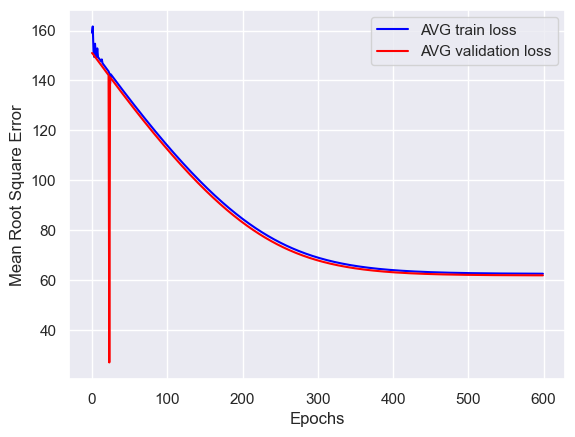

In [9]:
fig, ax = plt.subplots()
ax.plot(train_loss_mrse, color = "blue", label = "AVG train loss")
ax.plot(val_loss_mrse, color = "red", label = "AVG validation loss")
ax.set_xlabel("Epochs")
ax.set_ylabel("Mean Root Square Error")
plt.legend()
plt.show()